In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


os.getcwd()
ames_geo = pd.read_csv(r"C:\users\willf\OneDrive\Documents\NYDSA\Machine Learning Project\Machine Learning Project Proposal\ames_geo_final.csv", keep_default_na=False)

In [3]:
# Drop unknown, identifier, addresses, sale-price-related and one of highly correlated columns

ames_geo_mlprep = ames_geo.drop(columns=['Unnamed: 0', 'PID', 'Prop_Addr','LogSalePrice',  
                                         'TotRmsAbvGrd', 'NmbrBRs', 'FireplaceQu', 'GarageCond', 'PoolQC'])

ames_geo_mlprep.columns

Index(['GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'Functional', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'Scr

In [8]:
# Run XGboost with one-hot encoding and pipeline creation

import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

# Set up new pipeline for cross validation

# Define dataset
X = ames_geo_mlprep.drop('SalePrice', axis=1)
y = ames_geo_mlprep['SalePrice']

# Define transformer for one-hot encoding (excluding 'Neighborhood')
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('Neighborhood')

# Define target encoder for 'Neighborhood'
target_encoder = ce.TargetEncoder(cols=['Neighborhood'])

# Define transformer for one-hot encoding
xgb_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('target_enc', target_encoder, ['Neighborhood'])
    ], remainder='passthrough'
)

# Create a pipeline
xgb_pipeline = Pipeline(steps=[('preprocessor', xgb_preprocessor),
                           ('regressor', xgb.XGBRFRegressor(objective='reg:squarederror', random_state=42))])

# Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

# Fit the pipeline
xgb_pipeline.fit(X_train, y_train)

# Evaluate model
xgb_predictions = xgb_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
r_squared = r2_score(y_test, xgb_predictions)
print(f"RMSE: {rmse}")
print(f"R-squared: {r_squared}")

# Perform CV
scores = cross_val_score(xgb_pipeline, X, y, cv=5, scoring='r2')
print("Cross-validated R-squared scores:", scores)


RMSE: 27041.11498078551
R-squared: 0.880793839432823
Cross-validated R-squared scores: [0.87354911 0.87174852 0.87988177 0.90133434 0.87574394]


In [9]:
# Tune xgboost hyperparams

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# XGboost pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', xgb_preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Hyperparams grid
param_dist = {
    'regressor__n_estimators': randint(100,1000),
    'regressor__learning_rate': uniform(0.01, 0.6),
    'regressor__max_depth': randint(3, 10),
    'regressor__min_child_weight': randint(1, 6),
    'regressor__gamma': uniform(0, 0.5),
    'regressor__subsample': uniform(0.5, 0.5),
    'regressor__colsample_bytree': uniform(0.5, 0.5)
}

# Randomized search
random_search = RandomizedSearchCV(xgb_pipeline, param_distributions=param_dist,
                                   n_iter=100, cv=5, scoring='r2', random_state=42, n_jobs=-1)

# Fit random search model
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)

Best parameters: {'regressor__colsample_bytree': 0.6379995910112717, 'regressor__gamma': 0.1481367528520412, 'regressor__learning_rate': 0.1091601634378015, 'regressor__max_depth': 3, 'regressor__min_child_weight': 1, 'regressor__n_estimators': 443, 'regressor__subsample': 0.6974407590877849}


In [10]:
# Rerun XGboost on hyperparm optimized values

X = ames_geo_mlprep.drop('SalePrice', axis=1)
y = ames_geo_mlprep['SalePrice']

# Define transformer for one-hot encoding (excluding 'Neighborhood')
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('Neighborhood')

# Define target encoder for 'Neighborhood'
target_encoder = ce.TargetEncoder(cols=['Neighborhood'])

# Define transformer for one-hot encoding
xgb_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('target_enc', target_encoder, ['Neighborhood'])
    ], remainder='passthrough'
)

best_params_xgb = random_search.best_params_

# Create a pipeline with preprocessor and XGBoost regressor with the best parameters
best_xgb_pipeline = Pipeline([
    ('preprocessor', xgb_preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=best_params_xgb['regressor__n_estimators'],
                                   learning_rate=best_params_xgb['regressor__learning_rate'],
                                   max_depth=best_params_xgb['regressor__max_depth'],
                                   min_child_weight=best_params_xgb['regressor__min_child_weight'],
                                   gamma=best_params_xgb['regressor__gamma'],
                                   subsample=best_params_xgb['regressor__subsample'],
                                   colsample_bytree=best_params_xgb['regressor__colsample_bytree'],
                                   random_state=42))
])

# Fit the pipeline on the training data
best_xgb_pipeline.fit(X_train, y_train)

# Predict on the test data
xgb_predictions = best_xgb_pipeline.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
r_squared = r2_score(y_test, xgb_predictions)

print(f"RMSE: {rmse}")
print(f"R-squared: {r_squared}")


RMSE: 19861.13834741704
R-squared: 0.9356930689756581


I ran the model with target encoding the Neighborhood feature. Let's see if this feature now shows up as important

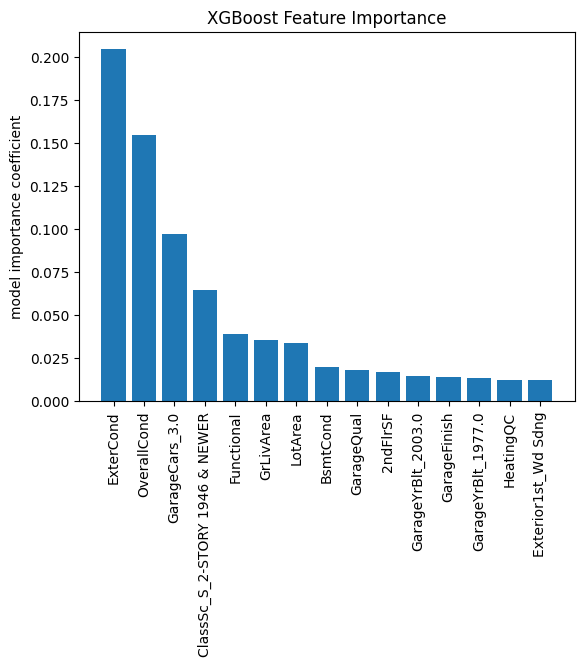

In [15]:
# Extract feature importance from best xgb model
xgb_feature_importances = best_xgb_pipeline.named_steps['regressor'].feature_importances_

# Get features names after one-hot encoding
encoded_features = best_xgb_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)

# Get numeric feature names
numeric_features = X.select_dtypes(exclude=['object']).columns

# Combine feature names
all_features = np.concatenate([encoded_features, numeric_features])

# Map feature importance to feature names
feature_importance_dict = dict(zip(all_features, xgb_feature_importances))

# Sort by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

xgb_feature_importance = pd.DataFrame(sorted_feature_importance, columns=['Feature', 'Importance'], index=None)

# Plot Feature Importance - top 15
import matplotlib.pyplot as plt

xgb_importance_15 = xgb_feature_importance.head(15)
plt.bar(xgb_importance_15['Feature'], xgb_importance_15['Importance'])
plt.xticks(rotation=90)
plt.ylabel('model importance coefficient')
plt.title("XGBoost Feature Importance")
plt.show()


Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
[10:02:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


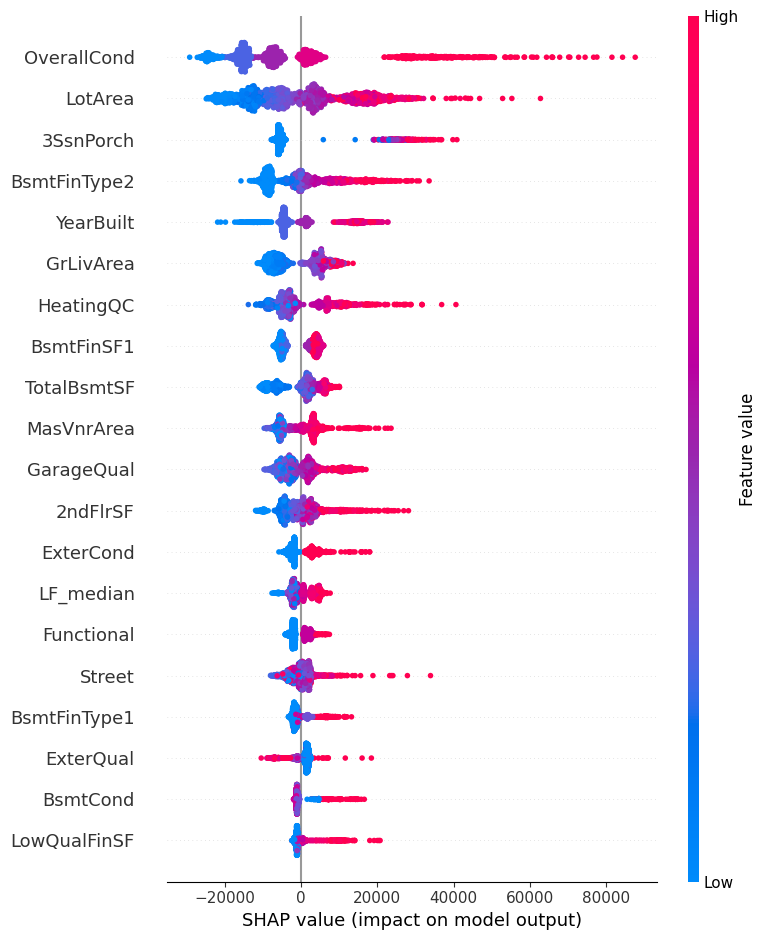

In [14]:
import shap
import scipy.sparse 
# Get XGBoost SHAP values
xgb_model = best_xgb_pipeline.named_steps['regressor']

# Preprocess using model preprocessor
X_train_preprocessed = best_xgb_pipeline.named_steps['preprocessor'].transform(X_train)

# Convert one-hot encoded data to dense format
if isinstance(X_train_preprocessed, scipy.sparse.csr.csr_matrix):
    X_train_preprocessed = X_train_preprocessed.toarray()


encoded_features = best_xgb_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
preprocessed_feature_names = np.concatenate([encoded_features, numeric_features])

# Create SHAP explainer
explainer = shap.Explainer(xgb_model, X_train_preprocessed)

shap_values = explainer(X_train_preprocessed)

shap.summary_plot(shap_values, X_train_preprocessed, feature_names=preprocessed_feature_names)
